In [1]:
basepath = '/data/conda/recnn/data'
trainfile,testfile = '/npyfiles/26Juin_anti-kt_train.npy','/npyfiles/26Juin_anti-kt_test.npy'
name = "anti-kt"
modelpath = '/models/model_anti-kt_26Juin.pickle'


trainfile=basepath+trainfile
testfile=basepath+testfile

In [2]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
np.seterr(divide="ignore")
sys.path.append("..")
from recnn.recnn import grnn_predict_simple
from recnn.recnn import grnn_predict_gated
from recnn.preprocessing import rewrite_content
from recnn.preprocessing import multithreadmap
from recnn.preprocessing import permute_by_pt
from recnn.preprocessing import extract

In [3]:
def extractcontent(jet):
    return(jet["content"])

def tftransform(jet,tf):
    """applies a robustscaler transform"""
    jet["content"] = tf.transform(jet["content"])
    return(jet)

def load_tf(X, y):
    """loads training data and make a robustscaler transform"""
    # Make training data
    X = multithreadmap(rewrite_content,X)
    X = multithreadmap(extract,X)
    Xcontent=multithreadmap(extractcontent,X)
    tf = RobustScaler().fit(np.vstack(Xcontent))
    return(tf)

def load_test(tf, X, y):
    """loads testing data"""
    # Make test data
    shuf = np.random.permutation(len(X))
    X=X[shuf]
    y=y[shuf]
    print("Preprocessing...")
    X = multithreadmap(rewrite_content,X)
    X = multithreadmap(permute_by_pt,X)
    X = multithreadmap(extract,X)
    X=multithreadmap(tftransform,X,tf=tf)
    return(X, y)

def roc_curve_perso(y, y_pred,density=1000):
    """return the roc curve"""
    back = np.argwhere(y==0)
    back = back.reshape((len(back),))
    sign = np.argwhere(y==1)
    sign=sign.reshape((len(sign),))
    #prediction
    y_pred_sign=y_pred[sign]
    y_pred_back=y_pred[back]
    t=np.linspace(0.,1.,density)
    tpr=np.zeros(density,dtype=float)
    fpr=np.zeros(density,dtype=float)
    for i in range(density):
        tpr[i]=np.sum(y_pred_sign<=t[i])
        fpr[i]=np.sum(y_pred_back<=t[i])
    tpr=1-tpr/len(y_pred_sign)
    fpr=1-fpr/len(y_pred_back)
    return(fpr,tpr,t)

In [4]:
def predict(X, filename, func=grnn_predict_simple):
    """make prediction function"""
    fd = open(filename, "rb")
    params = pickle.load(fd)
    fd.close()
    y_pred = func(params, X)
    return(y_pred)

def evaluate_models(X, y, filename, func=grnn_predict_simple):
    """evaluates a model"""
    print("Loading " + filename),
    y_pred = predict(X, filename, func=func)
    fpr, tpr, _ = roc_curve_perso(y, y_pred,density=100)
    roc = np.trapz(-tpr,fpr)
    print("ROC AUC = %.4f" % roc)
    return(roc, fpr, tpr)

def build_rocs(tf, X1, y1, model):
    X, y = load_test(tf, X1, y1) 
    roc, fpr, tpr = evaluate_models(X, y, model, func=grnn_predict_gated)
    return(roc, fpr, tpr)

In [5]:
### Load training data ###
X, y = np.load(trainfile)
X=np.array(X).astype(dict)
y = np.array(y).astype(int)

### eliminate single particles (now useless) ###
i=0
while i < len(y):
    if X[i]['tree'].shape == (1, 2):
        X,y=np.delete(X,i),np.delete(y,i)
    else :
        i+=1

### to rescale test data ###
tf = load_tf(X,y)

### Load test data ###
X1, y1 = np.load(testfile)
X1 = np.array(X1).astype(dict)
y1 = np.array(y1).astype(int)

### eliminate single particles (now useless) ###
i=0
while i < len(y1):
    if X1[i]['tree'].shape == (1, 2):
        X1,y1=np.delete(X1,i),np.delete(y1,i)
    else :
        i+=1

In [8]:
### Build the roc ###
r, f, t = build_rocs(tf, X1, y1, basepath+modelpath)
print(r)

Preprocessing...
Loading /data/conda/recnn/data/models/model_anti-kt_26Juin.pickle ROC AUC = 0.9579
0.9578751241006085


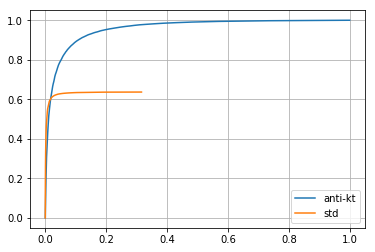

0.9578751241006085


In [37]:
plt.plot(f,t,label=name)
tpr,fpr = np.load('/data/conda/recnn/data/roccurves/standardID_ROC.npy')
plt.plot(fpr[1:],tpr[1:],label='std')
#plt.xscale("log")
plt.legend()
plt.grid()
#plt.yscale("log")
#plt.xlim([0.0001,0.1])
#plt.ylim([0.2,0.8])
plt.savefig("first_working_nn_roc.png",dpi=600)
plt.show()
print(r)